# Train `MNIST`

#### Imports

In [1]:
!pip install keras-core --quiet
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
from keras_core.datasets import mnist  # for mnist only
import jax
import jax.numpy as jnp
import functools as ft
import optax  # for gradient optimization
import serket as sk
import time
import matplotlib.pyplot as plt  # for plotting the predictions

EPOCHS = 1
LR = 1e-3
BATCH_SIZE = 128

Using JAX backend.


#### Data preparation

In [3]:
(x_train, y_train), _ = mnist.load_data()

x_train = x_train.reshape(-1, 1, 28, 28).astype("float32") / 255.0
x_train = jnp.array_split(x_train, x_train.shape[0] // BATCH_SIZE)
y_train = jnp.array_split(y_train, y_train.shape[0] // BATCH_SIZE)

#### Model creation

_**Style 1**_

In [4]:
k1, k2, k3 = jax.random.split(jax.random.PRNGKey(0), 3)

nn = sk.Sequential(
    sk.nn.Conv2D(1, 32, 3, key=k1, padding="valid"),
    jax.nn.relu,
    sk.nn.MaxPool2D(2, 2),
    sk.nn.Conv2D(32, 64, 3, key=k2, padding="valid"),
    jax.nn.relu,
    sk.nn.MaxPool2D(2, 2),
    jnp.ravel,
    sk.nn.Linear(1600, 10, key=k3),
)

_**Style 2**_

In [5]:
k1, k2, k3 = jax.random.split(jax.random.PRNGKey(0), 3)


@sk.autoinit
class ConvNet(sk.TreeClass):
    def __init__(self):
        self.conv1 = sk.nn.Conv2D(1, 32, 3, key=k1, padding="valid")
        self.pool1 = sk.nn.MaxPool2D(2, 2)
        self.conv2 = sk.nn.Conv2D(32, 64, 3, key=k2, padding="valid")
        self.pool2 = sk.nn.MaxPool2D(2, 2)
        self.linear = sk.nn.Linear(1600, 10, key=k3)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.pool1(jax.nn.relu(self.conv1(x)))
        x = self.pool2(jax.nn.relu(self.conv2(x)))
        x = self.linear(jnp.ravel(x))
        return x


nn = ConvNet()

#### Visualize tree

In [6]:
print("depth=0")
print(sk.tree_summary(nn, depth=0))
print("depth=1")
print(sk.tree_summary(nn, depth=1))

depth=0
┌────┬───────┬──────┬────────┐
│Name│Type   │Count │Size    │
├────┼───────┼──────┼────────┤
│Σ   │ConvNet│34,866│136.04KB│
└────┴───────┴──────┴────────┘
depth=1
┌───────┬─────────┬──────┬────────┐
│Name   │Type     │Count │Size    │
├───────┼─────────┼──────┼────────┤
│.conv1 │Conv2D   │332   │1.25KB  │
├───────┼─────────┼──────┼────────┤
│.pool1 │MaxPool2D│6     │        │
├───────┼─────────┼──────┼────────┤
│.conv2 │Conv2D   │18,508│72.25KB │
├───────┼─────────┼──────┼────────┤
│.pool2 │MaxPool2D│6     │        │
├───────┼─────────┼──────┼────────┤
│.linear│Linear   │16,014│62.54KB │
├───────┼─────────┼──────┼────────┤
│Σ      │ConvNet  │34,866│136.04KB│
└───────┴─────────┴──────┴────────┘


#### Training functions

In [7]:
# 1) mask the non-jaxtype parameters
nn = sk.tree_mask(nn)

# 2) initialize the optimizer state
optim = optax.adam(LR)
optim_state = optim.init(nn)


@jax.vmap
def softmax_cross_entropy(logits, onehot):
    assert onehot.shape == logits.shape == (10,)
    return -jnp.sum(jax.nn.log_softmax(logits) * onehot)


@ft.partial(jax.grad, has_aux=True)
def loss_func(nn, x, y):
    # 3) unmask the non-jaxtype parameters to be used in the computation.
    # The tree must be masked -using sk.tree_mask` before being passed to the
    # loss function. Because `jax.grad` will not be able to differentiate through
    # the tree if the tree contains non-jaxtype parameters (e.g. anything that is not
    # a float/float array/complex/complex array like activation function or strings).
    # So we mask before passing to the loss function, and unmask before calling the
    # neural network, thus rendering the non-jaxtype parameters *invisible* to `jax.grad`
    nn = sk.tree_unmask(nn)

    # 4) vectorize the computation over the batch
    logits = jax.vmap(nn)(x)
    onehot = jax.nn.one_hot(y, 10)

    # 5) use the appropriate loss function
    loss = jnp.mean(softmax_cross_entropy(logits, onehot))
    return loss, (loss, logits)


@jax.vmap
def accuracy_func(logits, y):
    assert logits.shape == (10,)
    return jnp.argmax(logits) == y


@jax.jit
def train_step(nn, optim_state, x, y):
    # the loss function will have an output of (loss, logits)
    # as an auxillary output, and will have a gradient `grads` of same
    # structure as the input
    grads, (loss, logits) = loss_func(nn, x, y)

    # 6) update the parameters using the optimizer
    updates, optim_state = optim.update(grads, optim_state)
    nn = optax.apply_updates(nn, updates)
    return nn, optim_state, (loss, logits)

#### Train and plot results

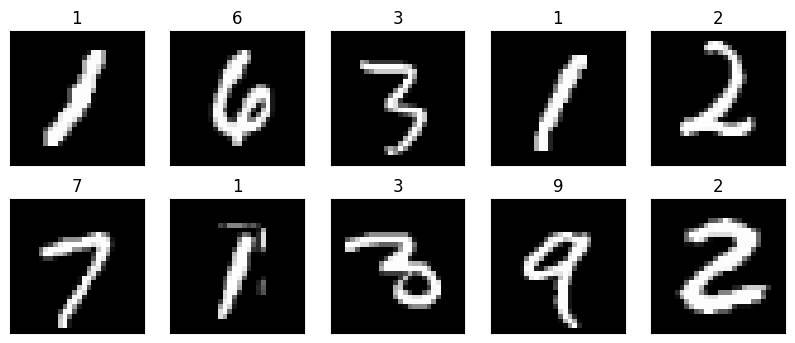

In [8]:
for i in range(1, EPOCHS + 1):
    t0 = time.time()
    for j, (xb, yb) in enumerate(zip(x_train, y_train)):
        nn, optim_state, (loss, logits) = train_step(nn, optim_state, xb, yb)
        accuracy = jnp.mean(accuracy_func(logits, yb))
        print(
            f"Epoch: {i:003d}/{EPOCHS:003d}\t"
            f"Batch: {j+1:003d}/{len(x_train):003d}\t"
            f"Batch loss: {loss:3e}\t"
            f"Batch accuracy: {accuracy:3f}\t"
            f"Time: {time.time() - t0:.3f}",
            end="\r",
        )

# 6) un-mask the trained network
nn = sk.tree_unmask(nn)

# create 2x5 grid of images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
idxs = jax.random.randint(k1, shape=(10,), minval=0, maxval=x_train[0].shape[0])

for i, idx in zip(axes.flatten(), idxs):
    # get the prediction
    pred = nn(x_train[0][idx])
    # plot the image
    i.imshow(x_train[0][idx].reshape(28, 28), cmap="gray")
    # set the title to be the prediction
    i.set_title(jnp.argmax(pred))
    i.set_xticks([])
    i.set_yticks([])